In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)

/root/NewEnvPy39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import pandas as pd
df = pd.read_json('/root/llama/datasets/preprocessed_dataset.json')

In [3]:
from datasets import Dataset

# Convert the pandas DataFrame to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

In [5]:
hf_dataset
from datasets import load_dataset

# Step 1: Define a cleaning function
def clean_text(example):
    # Replace newline characters with space
    example['title'] = example['title'].replace('\n', ' ')
    example['summary'] = example['summary'].replace('\n', ' ')
    # Replace apostrophes with empty string
    example['title'] = example['title'].replace('\'', '')
    example['summary'] = example['summary'].replace('\'', '')

    # Add more cleaning steps as needed
    return example

# Step 3: Apply the cleaning function
cleaned_dataset = hf_dataset.map(clean_text)

# Step 4: Inspect a few records to ensure cleaning is done
print(cleaned_dataset[0:2])

# Save the cleaned dataset if needed
#cleaned_dataset.save_to_disk('/path/to/save/dataset')


Map:   0%|          | 0/41000 [00:00<?, ? examples/s]

Map: 100%|██████████| 41000/41000 [00:04<00:00, 9142.25 examples/s] 

{'title': ['dual recurrent attention units for visual question answering', 'sequential shorttext classification with recurrent and convolutional   neural networks'], 'summary': ['we propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question our single model outperforms the first place winner on the vqa 10 dataset performs within margin to the current stateoftheart ensemble model we also experiment with replacing attention mechanisms in other stateoftheart models with our implementation and show increased accuracy in both cases our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset', 'recent approaches based on artificial neural networks anns have shown p

In [6]:
print(cleaned_dataset[0])  # Print the first entry to check its structure


{'title': 'dual recurrent attention units for visual question answering', 'summary': 'we propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question our single model outperforms the first place winner on the vqa 10 dataset performs within margin to the current stateoftheart ensemble model we also experiment with replacing attention mechanisms in other stateoftheart models with our implementation and show increased accuracy in both cases our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset', '__index_level_0__': 0}


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards: 100%|██████████| 3/3 [00:52<00:00, 17.48s/it]


In [13]:
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [28]:

#zero shot learning
#prompts = [
#    f"The following is a research paper in the fields of Machine Learning, Artificial Intelligence and other related subfields. Please provide a concise summary that covers its main points and conclusions for the paper titled \"{cleaned_dataset[i]['title']}\"."
#    for i in range(50)
#]

#few shot learning
#prompts = [
#    f'Given a research paper title, provide a detailed summary that covers the main objectives, methods, findings, and conclusions.\n'
#    f'For example:\n'
#    f'For the title "Dual Recurrent Attention Units for Visual Question Answering", '
#    f'the summary introduces an innovative architecture with dual recurrent attention units, discussing its mechanisms for enhancing visual and textual analysis and its general performance improvements.\n\n'
#    f'Now, provide a summary for: "{cleaned_dataset[i]["title"]}"'
#    for i in range(1, min(51, len(cleaned_dataset)))
#]

# chain-of-thoughts
prompts = [
    f'Given a research paper title, "{cleaned_dataset[i]["title"]}", provide a detailed summary:\n'
    f'1. Identify the main objectives of the research.\n'
    f'2. Describe the methods used to achieve these objectives.\n'
    f'3. Summarize the key findings and conclusions.\n'
    f'Your summary should be a single, cohesive paragraph without section breaks, where objectives, methods, and conclusions are not stated obviously but explained naturally.'
    for i in range(0, min(50, len(cleaned_dataset)))
]

In [29]:
#postprocessing and cleaning the summary for more accurate evaluation
import re
def condense_summary(summary):
    # Remove headings and numbers
    summary = re.sub(r'(\n### .+\n)|(\d+\.\s)', '', summary)

    # Split into sentences
    sentences = re.split(r'\.\s+', summary)

    # Remove duplicate sentences
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            unique_sentences.append(sentence)
            seen.add(sentence)

    # Join sentences into a paragraph
    condensed_summary = '. '.join(unique_sentences)

    return condensed_summary.strip()

model_outputs = []
for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output_ids = model.generate(input_ids, max_length=250, temperature=0.4, top_p=0.6)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Post-processing to remove the echoed prompt
    if generated_text.startswith(prompt):
        generated_text = generated_text[len(prompt):].strip()

    # Condense the generated text
    condensed_text = condense_summary(generated_text)

    model_outputs.append(condensed_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

In [30]:
#extract generated plus actual summaries
generated_summaries = model_outputs
actual_summaries = [cleaned_dataset[i]['summary'] for i in range(50)]

In [31]:
# Printing and comparing the first 2 model-generated summaries with the actual summaries
for i in range(2):
    print(f"Prompt:\n{prompts[i]}\n")
    print(f"Generated Summary:\n{generated_summaries[i]}\n")
    print(f"Actual Summary:\n{actual_summaries[i]}\n")
    print("---------------------------------------------------\n")

Prompt:
Given a research paper title, "dual recurrent attention units for visual question answering", provide a detailed summary:
1. Identify the main objectives of the research.
2. Describe the methods used to achieve these objectives.
3. Summarize the key findings and conclusions.
Your summary should be a single, cohesive paragraph without section breaks, where objectives, methods, and conclusions are not stated obviously but explained naturally.

Generated Summary:
This paper proposes a novel approach to visual question answering (VQA) using dual recurrent attention units. The primary objective is to improve the performance of VQA models by allowing them to selectively focus on relevant visual and textual features. To achieve this, the authors introduce a dual attention mechanism that consists of a visual attention module and a textual attention module. These attention modules are implemented using recurrent neural networks (RNNs) and are applied in parallel to the input visual and 

In [32]:
# Specify the index you want to focus on
index = 2  # Replace 0 with the desired index

# Printing and comparing the model-generated summary with the actual summary for the specified index
print(f"Prompt:\n{prompts[index]}\n")
print(f"Generated Summary:\n{generated_summaries[index]}\n")
print(f"Actual Summary:\n{actual_summaries[index]}\n")
print("---------------------------------------------------\n")


Prompt:
Given a research paper title, "multiresolution recurrent neural networks an application to dialogue   response generation", provide a detailed summary:
1. Identify the main objectives of the research.
2. Describe the methods used to achieve these objectives.
3. Summarize the key findings and conclusions.
Your summary should be a single, cohesive paragraph without section breaks, where objectives, methods, and conclusions are not stated obviously but explained naturally.

Generated Summary:
This paper proposes the application of multiresolution recurrent neural networks (MRRNNs) to the task of dialogue response generation. The main objective is to improve the quality and diversity of generated responses by incorporating multiple time scales into the neural network architecture. The authors achieve this by extending traditional recurrent neural networks (RNNs) with multiresolution dilated convolutions, which allow the network to capture information at different time scales. The M

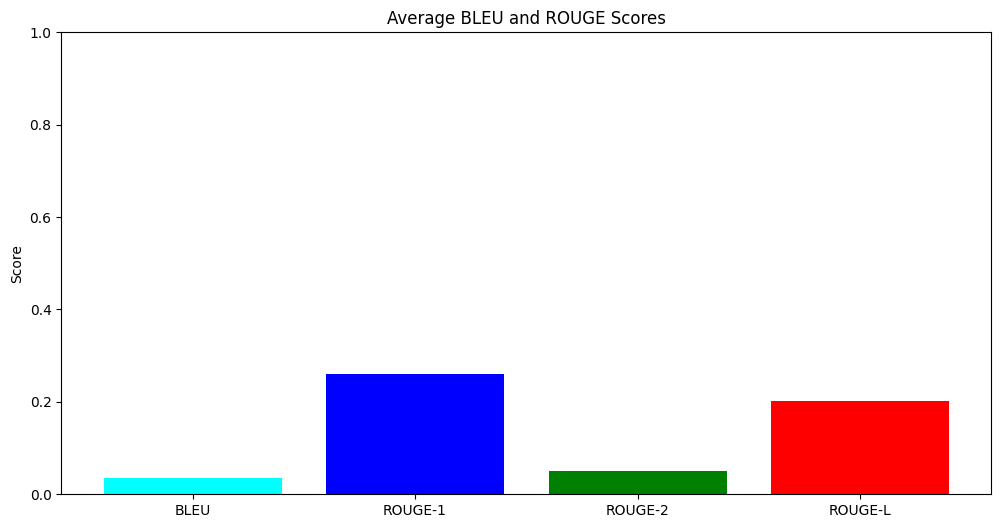

Average BLEU Score: 0.0345
Average ROUGE-1 F1 Score: 0.2610
Average ROUGE-2 F1 Score: 0.0509
Average ROUGE-L F1 Score: 0.2014


In [33]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import numpy as np
import matplotlib.pyplot as plt

def calculate_bleu_scores(actual_summaries, generated_summaries):
    # Calculate BLEU scores for each summary pair
    # Ensure the summaries are split into words (tokens)
    smoothie = SmoothingFunction().method2
    bleu_scores = [sentence_bleu([actual.split()], generated.split(), smoothing_function=smoothie) for actual, generated in zip(actual_summaries, generated_summaries)]
    return bleu_scores

def calculate_rouge_scores(actual_summaries, generated_summaries):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summaries, actual_summaries, avg=True)
    return rouge_scores

# Ensure that actual_summaries and generated_summaries are lists of strings
# Calculate scores
bleu_scores = calculate_bleu_scores(actual_summaries, generated_summaries)
avg_bleu_score = np.mean(bleu_scores)
rouge_scores = calculate_rouge_scores(actual_summaries, generated_summaries)

# Extract average F1 scores for each ROUGE metric
rouge_1_f1 = rouge_scores['rouge-1']['f']
rouge_2_f1 = rouge_scores['rouge-2']['f']
rouge_l_f1 = rouge_scores['rouge-l']['f']

# Plotting
plt.figure(figsize=(12, 6))
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_bleu_score, rouge_1_f1, rouge_2_f1, rouge_l_f1]

plt.bar(metrics, scores, color=['cyan', 'blue', 'green', 'red'])
plt.title('Average BLEU and ROUGE Scores')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming the scores are normalized between 0 and 1
plt.show()

# Printing BLEU and ROUGE scores
print(f"Average BLEU Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE-1 F1 Score: {rouge_1_f1:.4f}")
print(f"Average ROUGE-2 F1 Score: {rouge_2_f1:.4f}")
print(f"Average ROUGE-L F1 Score: {rouge_l_f1:.4f}")
